In [22]:
%load_ext autoreload
%autoreload 1
from pathlib import Path

import pandas as pd
import seaborn as sns
import torch
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch.utils.data import Subset, WeightedRandomSampler
# from torch.utils.data import DataLoader
from src.utils.seeder import seed_everything

# set seaborn theme
sns.set_theme()

# create useful constants
RANDOM_SEED = 42
IS_SCITAS = False # set to True if running on SCITAS cluster
LOCAL_DATA_ROOT = Path("./data")
DATA_ROOT = Path("/home/ogut/data") if IS_SCITAS else LOCAL_DATA_ROOT
CHECKPOINT_ROOT = Path("./.checkpoints")
SUBMISSION_ROOT = Path("./.submissions")

# create directories if they do not exist
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
SUBMISSION_ROOT.mkdir(parents=True, exist_ok=True)

# set dataset root
seed_everything(RANDOM_SEED)

# setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


In [16]:
# import subprocess

# # execute feature extraction script
# try:
#     process = subprocess.Popen(["python3", "scripts/feature_extractor.py"])
#     process.wait()
# except KeyboardInterrupt:
#     print("Process interrupted, terminating...")
#     process.terminate()
#     process.wait()
# except Exception as e:
#     print(f"Error occurred: {e}")
#     if 'process' in locals():
#         process.terminate()
#         process.wait()

In [35]:
# spacial distance matrix between sensors
spatial_distance_file = LOCAL_DATA_ROOT / "distances_3d.csv"

# training data
train_dir = DATA_ROOT / "train"
train_dir_metadata = train_dir / "segments.parquet"
train_dataset_dir = LOCAL_DATA_ROOT / "graph_dataset_train"

# test data
test_dir = DATA_ROOT / "test"
test_dir_metadata = test_dir / "segments.parquet"
test_dataset_dir = LOCAL_DATA_ROOT / "graph_dataset_test"

# additional features
extracted_features_dir = LOCAL_DATA_ROOT / "extracted_features"
embeddings_dir =  LOCAL_DATA_ROOT / "embeddings"

In [38]:
from src.utils.index import ensure_eeg_multiindex 

# Load clips from datasets
clips_tr = pd.read_parquet(train_dir_metadata)
clips_tr = ensure_eeg_multiindex(clips_tr)
clips_tr['id'] = clips_tr.index.map(lambda x: '_'.join(str(i) for i in x))
assert clips_tr.id.nunique() == len(clips_tr), "There are duplicate IDs"
clips_tr = clips_tr[~clips_tr.label.isna()].reset_index()

# Load clips from datasets
clips_te = pd.read_parquet(test_dir_metadata)
clips_te = ensure_eeg_multiindex(clips_te)
clips_te['id'] = clips_te.index.map(lambda x: '_'.join(str(i) for i in x))
assert clips_te.id.nunique() == len(clips_te), "There are duplicate IDs"
clips_te = clips_te.reset_index()

# sort in order to maintain the same submission order
clips_te = clips_te.sort_values(by="id")

In [40]:
%aimport
from src.data.dataset_graph import GraphEEGDataset

# dataset settings
selected_features = []
embeddings = []
edge_strategy = "spatial"
correlation_threshold = 0.5
top_k = None
low_bandpass_frequency = 0.5
high_bandpass_frequency = 50

# additional settings
oversampling_power = 1.0

# load training dataset
dataset_tr = GraphEEGDataset(
    root=train_dataset_dir,
    clips=clips_tr,
    signal_folder=train_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy=edge_strategy,
    spatial_distance_file=(
        spatial_distance_file if edge_strategy == "spatial" else None
    ),
    top_k=top_k,
    correlation_threshold=correlation_threshold,
    force_reprocess=True,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
)

# Check the length of the dataset
print(f"Length of train_dataset: {len(dataset_tr)}")
print(f' Eliminated IDs: {dataset_tr.ids_to_eliminate}')

# Eliminate ids that did not have electrodes above correlation threshols
clips_tr = clips_tr[~clips_tr.index.isin(dataset_tr.ids_to_eliminate)].reset_index(drop=True)

2025-06-08 00:49:02 - INFO - Initializing GraphEEGDataset...
2025-06-08 00:49:02 - INFO - Dataset parameters:
2025-06-08 00:49:02 - INFO -   - Root directory: data/graph_dataset_train
2025-06-08 00:49:02 - INFO -   - Edge strategy: spatial
2025-06-08 00:49:02 - INFO -   - Top-k neighbors: None
2025-06-08 00:49:02 - INFO -   - Correlation threshold: 0.5
2025-06-08 00:49:02 - INFO -   - Force reprocess: True
2025-06-08 00:49:02 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-08 00:49:02 - INFO -   - Segment length: 3000
2025-06-08 00:49:02 - INFO -   - Apply filtering: True
2025-06-08 00:49:02 - INFO -   - Apply rereferencing: True
2025-06-08 00:49:02 - INFO -   - Apply normalization: True
2025-06-08 00:49:02 - INFO -   - Sampling rate: 250
2025-06-08 00:49:02 - INFO -   - Test mode: False
2025-06-08 00:49:02 - INFO - Number of EEG channels: 19
2025-06-08 00:49:02 - INFO - Setting up signal filters...
2025-06-08 00:49:02 - INFO - Loading spatial distances from data/distances_3d.csv


Modules to reload:


Modules to skip:



2025-06-08 00:49:02 - INFO - Preprocessed signal shape: (302250, 19)
2025-06-08 00:49:02 - INFO - Processed 0 segments so far
2025-06-08 00:49:02 - INFO - Session 1 processed in 0.38s
2025-06-08 00:49:02 - INFO - Processing session 2/177 (Patient pqejgcpt, Session s2_t1)
2025-06-08 00:49:03 - INFO - Preprocessed signal shape: (328000, 19)
2025-06-08 00:49:03 - INFO - Processed 100 segments so far
2025-06-08 00:49:03 - INFO - Processed 200 segments so far
2025-06-08 00:49:03 - INFO - Session 2 processed in 0.40s
2025-06-08 00:49:03 - INFO - Processing session 3/177 (Patient pqejgcpt, Session s3_t1)
2025-06-08 00:49:03 - INFO - Preprocessed signal shape: (345750, 19)
2025-06-08 00:49:03 - INFO - Processed 300 segments so far
2025-06-08 00:49:03 - INFO - Session 3 processed in 0.41s
2025-06-08 00:49:03 - INFO - Processing session 4/177 (Patient pqejgcsv, Session s1_t0)
2025-06-08 00:49:03 - INFO - Preprocessed signal shape: (128500, 19)
2025-06-08 00:49:03 - INFO - Session 4 processed in 

Length of train_dataset: 12993
 Eliminated IDs: []


In [33]:
print(clips_te.index.names)

['patient', 'session', 'segment']


In [41]:
%aimport
from src.data.dataset_graph import GraphEEGDataset

# load test dataset
te_dataset = GraphEEGDataset(
    root=test_dataset_dir,
    clips=clips_te,
    signal_folder=test_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy="spatial",
    spatial_distance_file=spatial_distance_file,
    top_k=None,
    correlation_threshold=0.5,
    force_reprocess=True,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=False,
    apply_normalization=False,
    sampling_rate=250,
    is_test = True,
)

# Check the length of the dataset
print(f"Length of test_dataset: {len(te_dataset)}")
print(f' Eliminated IDs:{te_dataset.ids_to_eliminate}')

# Eliminate ids that did not have electrodes above correlation threshols
clips_te = clips_te[~clips_te.index.isin(te_dataset.ids_to_eliminate)].reset_index(drop=True)

2025-06-08 00:49:54 - INFO - Initializing GraphEEGDataset...
2025-06-08 00:49:54 - INFO - Dataset parameters:
2025-06-08 00:49:54 - INFO -   - Root directory: data/graph_dataset_test
2025-06-08 00:49:54 - INFO -   - Edge strategy: spatial
2025-06-08 00:49:54 - INFO -   - Top-k neighbors: None
2025-06-08 00:49:54 - INFO -   - Correlation threshold: 0.5
2025-06-08 00:49:54 - INFO -   - Force reprocess: True
2025-06-08 00:49:54 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-08 00:49:54 - INFO -   - Segment length: 3000
2025-06-08 00:49:54 - INFO -   - Apply filtering: True
2025-06-08 00:49:54 - INFO -   - Apply rereferencing: False
2025-06-08 00:49:54 - INFO -   - Apply normalization: False
2025-06-08 00:49:54 - INFO -   - Sampling rate: 250
2025-06-08 00:49:54 - INFO -   - Test mode: True
2025-06-08 00:49:54 - INFO - Number of EEG channels: 19
2025-06-08 00:49:54 - INFO - Setting up signal filters...
2025-06-08 00:49:54 - INFO - Loading spatial distances from data/distances_3d.csv


Modules to reload:


Modules to skip:



2025-06-08 00:49:54 - INFO - Preprocessed signal shape: (65500, 19)
2025-06-08 00:49:54 - INFO - Session 3 processed in 0.09s
2025-06-08 00:49:54 - INFO - Processing session 4/50 (Patient pqejgdix, Session s2_t1)
2025-06-08 00:49:54 - INFO - Preprocessed signal shape: (88500, 19)
2025-06-08 00:49:55 - INFO - Session 4 processed in 0.09s
2025-06-08 00:49:55 - INFO - Processing session 5/50 (Patient pqejgdix, Session s2_t2)
2025-06-08 00:49:55 - INFO - Preprocessed signal shape: (69250, 19)
2025-06-08 00:49:55 - INFO - Processed 100 segments so far
2025-06-08 00:49:55 - INFO - Session 5 processed in 0.08s
2025-06-08 00:49:55 - INFO - Processing session 6/50 (Patient pqejgdix, Session s2_t4)
2025-06-08 00:49:55 - INFO - Preprocessed signal shape: (76000, 19)
2025-06-08 00:49:55 - INFO - Session 6 processed in 0.08s
2025-06-08 00:49:55 - INFO - Processing session 7/50 (Patient pqejgdix, Session s2_t5)
2025-06-08 00:49:55 - INFO - Preprocessed signal shape: (73500, 19)
2025-06-08 00:49:55 -

Length of test_dataset: 3614
 Eliminated IDs:[]


In [42]:
from torch.utils.data import random_split
from src.utils.general_funcs import labels_stats

# Get total samples and split sizes
total_samples = len(dataset_tr)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# Get labels for initial split
y = clips_tr["label"].values

# Create initial train/val split using random permutation
indices = torch.randperm(total_samples)
train_indices = indices[:train_size].numpy()
val_indices = indices[train_size:].numpy()

print('Labels before split', flush=True)
print(y, flush=True)

# Print stats for class 0 and 1
labels_stats(y, train_indices, val_indices)

# Create train and val datasets
train_dataset = Subset(dataset_tr, train_indices)
val_dataset = Subset(dataset_tr, val_indices)

# 3. Compute sample weights for oversampling
train_labels = [clips_tr.iloc[i]["label"] for i in train_indices]
class_counts = np.bincount(train_labels)
class_weights = (1. / class_counts) ** oversampling_power  # Higher weights for not frequent classes
sample_weights = [class_weights[label] for label in train_labels]  # Assign weight to each sample based on its class

# 4. Define sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Define dataloaders
BATCH_SIZE = 64
train_loader = GeoDataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler, 
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)
val_loader = GeoDataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)
te_loader = GeoDataLoader(
    te_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(te_loader)}")

Labels before split
[1 1 1 ... 1 1 0]
[00:52:04] Train labels: 0 -> 8375, 1 -> 2019
[00:52:04] Val labels:   0 -> 2101, 1 -> 498
Train batches: 163
Val batches: 41
Test batches: 57


In [43]:
%aimport
from src.layers.hybrid.cnn_bilstm_gcn import EEGCNNBiLSTMGCN

config = {
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "patience": 10,
    "epochs": 100,
}

Modules to reload:


Modules to skip:



### Test 3 - First breakthrough model

```
Epochs:   2%| | 2/100 [03:21<5:28:40, 201.23s/it, train_loss=0.7174, val_loss=0.5724, best_val_f1=0.0848, lr=3.00e-04, b2025-06-05 13:32:42 - INFO - 
Epochs:   3%| | 3/100 [06:28<5:12:31, 193.31s/it, train_loss=0.6813, val_loss=0.5767, best_val_f1=0.1734, lr=3.00e-04, b2025-06-05 13:35:50 - INFO - 
Epochs:   4%| | 4/100 [09:26<4:57:36, 186.00s/it, train_loss=0.6638, val_loss=0.6072, best_val_f1=0.1734, lr=3.00e-04, b2025-06-05 13:38:47 - INFO - 
Epochs:   5%| | 5/100 [12:26<4:50:40, 183.58s/it, train_loss=0.6704, val_loss=0.5754, best_val_f1=0.2178, lr=3.00e-04, b2025-06-05 13:41:47 - INFO - 
...
Epochs:   7%| | 7/100 [19:21<5:10:58, 200.62s/it, train_loss=0.6333, val_loss=0.5949, best_val_f1=0.3921, lr=3.00e-04, b2025-06-05 13:48:43 - INFO - 
Epochs:   8%| | 8/100 [23:11<5:22:14, 210.15s/it, train_loss=0.6261, val_loss=0.5993, best_val_f1=0.3921, lr=3.00e-04, b2025-06-05 13:52:33 - INFO - 
Epochs:   9%| | 9/100 [26:35<5:15:33, 208.06s/it, train_loss=0.6043, val_loss=0.5743, best_val_f1=0.3921, lr=3.00e-04, b2025-06-05 13:55:56 - INFO - 
...
Epochs:  12%| | 12/100 [36:17<4:49:57, 197.70s/it, train_loss=0.5935, val_loss=0.5691, best_val_f1=0.5043, lr=3.00e-04, 2025-06-05 14:05:38 - INFO - 
Epochs:  13%|▏| 13/100 [39:27<4:43:05, 195.24s/it, train_loss=0.5701, val_loss=0.5855, best_val_f1=0.5380, lr=3.00e-04, 2025-06-05 14:08:48 - INFO - 
Epochs:  14%|▏| 14/100 [42:32<4:35:35, 192.27s/it, train_loss=0.5329, val_loss=0.6952, best_val_f1=0.5380, lr=3.00e-04, 2025-06-05 14:11:54 - INFO -
Epochs:  18%|▏| 18/100 [55:14<4:22:12, 191.86s/it, train_loss=0.5042, val_loss=0.5616, best_val_f1=0.5623, lr=3.00e-04, 2025-06-05 14:24:36 - INFO -
Epochs:  19%|▏| 19/100 [58:26<4:19:03, 191.89s/it, train_loss=0.5092, val_loss=0.4702, best_val_f1=0.6405, lr=3.00e-04, 2025-06-05 14:27:48 - INFO - 
Epochs:  20%|▏| 20/100 [04:25<5:53:37, 265.22s/it, train_loss=0.5077, val_loss=0.4850, best_val_f1=0.6405, lr=3.00e-04, 2025-06-05 15:35:20 - INFO - 
Epochs:  21%|▏| 21/100 [07:55<5:06:16, 232.62s/it, train_loss=0.4657, val_loss=0.4666, best_val_f1=0.6405, lr=3.00e-04, 2025-06-05 15:38:49 - INFO - 
...
Epochs:  23%|▏| 23/100 [16:40<5:02:39, 235.83s/it, train_loss=0.4786, val_loss=0.4441, best_val_f1=0.6405, lr=3.00e-04, 2025-06-05 15:24:57 - INFO -
Epochs:  24%|▏| 24/100 [18:00<4:20:53, 205.96s/it, train_loss=0.4688, val_loss=0.5586, best_val_f1=0.6405, lr=3.00e-04, 2025-06-05 15:48:55 - INFO - 
Epochs:  25%|▎| 25/100 [21:08<4:09:36, 199.69s/it, train_loss=0.4521, val_loss=0.4014, best_val_f1=0.6484, lr=3.00e-04, 2025-06-05 15:52:02 - INFO - 
Epochs:  26%|▎| 26/100 [24:09<3:58:50, 193.65s/it, train_loss=0.4378, val_loss=0.3937, best_val_f1=0.6800, lr=3.00e-04, 2025-06-05 15:55:04 - INFO - 
... FROM HERE NOTHING...
Epochs:  31%|▎| 31/100 [39:30<3:35:33, 187.44s/it, train_loss=0.4061, val_loss=0.4341, best_val_f1=0.6800, lr=3.00e-04, 2025-06-05 16:10:25 - INFO - 
Epochs:  32%|▎| 32/100 [18:51<3:20:29, 176.90s/it, train_loss=0.3984, val_loss=0.4484, best_val_f1=0.6800, lr=3.00e-04, 2025-06-05 18:22:51 - INFO - 
Epochs:  35%|▎| 35/100 [52:42<3:31:23, 195.13s/it, train_loss=0.3835, val_loss=0.4302, best_val_f1=0.6800, lr=3.00e-04, 2025-06-05 16:23:36 - INFO - 
Epochs:  37%|▎| 37/100 [32:44<2:56:23, 168.00s/it, train_loss=0.3619, val_loss=0.4276, best_val_f1=0.6800, lr=3.00e-04, 2025-06-05 18:36:45 - INFO - 


In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_first_best_model.pt"
first_best_model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_use_batch_norm= True,
    lstm_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 128,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 3,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)

### Test 4 - Smaller CGN output channels

```
Epochs:  29%|▎| 29/100 [2:32:36<6:26:13, 326.39s/it, train_loss=0.3669, val_loss=0.4361, best_val_f1=0.6758, lr=3.00e-042025-06-05 21:22:07 - INFO - 
Epochs:  30%|▎| 30/100 [2:38:01<6:20:19, 326.00s/it, train_loss=0.3709, val_loss=0.5588, best_val_f1=0.6758, lr=3.00e-042025-06-05 21:27:32 - INFO - 
```


In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_first_best_model_bigger_gcn_output_channels.pt"

new_model_smaller_gcn_output = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_use_batch_norm= True,
    lstm_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 64,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 3,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)

### Test 6 - Smaller GCN output channels + increased embedding length + Deeper GCN

```
Epochs:   2%| | 2/100 [04:54<8:01:46, 294.97s/it, train_loss=0.5635, val_loss=0.6869, best_val_f1=0.5291, lr=1.00e-03, b2025-06-06 00:08:26 - INFO - 
Epochs:  26%|▎| 26/100 [1:16:00<3:35:35, 174.81s/it, train_loss=0.2740, val_loss=0.4044, best_val_f1=0.7278, lr=6.25e-052025-06-06 01:19:31 - INFO - 
```

In [ ]:
model_small_gcn_bigger_embedding = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_use_batch_norm= True,
    lstm_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 64,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)


### Test 7: Same as T6 but slighly bigger GCN output channels
>[HIGHEST F1 SCORE EVER RECORDED]
```
✅ Checkpoint loaded. Resuming from epoch 33. Best 'val_f1' score: 0.7346
```

In [55]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_bigger_gcn_bigger_embedding.pt"
model_bigger_gcn_bigger_embedding = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_use_batch_norm= True,
    lstm_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 96,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)

In [56]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_bigger_gcn_bigger_embedding_attention.pt"
from src.layers.hybrid.cnn_bilstm_attention_gcn import EEGCNNBiLSTMAttentionGNN
model_bigger_gcn_bigger_embedding = EEGCNNBiLSTMAttentionGNN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_use_batch_norm= True,
    lstm_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 96,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)

ModuleNotFoundError: No module named 'layers'

### Test 7B: Alternative architecture to improve generalization

```
Epochs:   6%| | 6/100 [11:12<3:31:19, 134.89s/it, train_loss=0.5436, val_loss=0.4397, best_val_f1=0.5160, lr=1.00e-04, b2025-06-06 18:28:03 - INFO - 
...
Epochs:  22%|▏| 22/100 [47:24<2:55:59, 135.38s/it, train_loss=0.4128, val_loss=0.3321, best_val_f1=0.6864, lr=1.25e-05, 2025-06-06 19:04:15 - INFO - 
```


In [ ]:
#  ✅ Checkpoint loaded. Resuming from epoch 37. Best 'val_f1' score: 0.7191
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable.pt"
model_generalizable = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.35, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.35, # slightly higher dropout to avoid overfitting
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 96,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

### Test 7C: slightly bigger GCN layers

BEST MODEL YET!

In [ ]:

SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_bigger.pt"
model_generalizable_bigger = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 192,
    gcn_out_channels = 128,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

### Test 7D: even bigger GCN layers

Comparable performance to best model. We might need to increase the number of GCN layers

In [ ]:

SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_even_bigger.pt"
model_generalizable_even_bigger = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 224,
    gcn_out_channels = 192,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

### Test 7E: increased number of GCN layers

Assumption: the previous model was unable to learn enough, maybe the GCN was unable to capture

```
Epochs:   9%| | 9/100 [17:54<3:23:31, 134.20s/it, train_loss=0.4532, val_loss=0.3489, best_val_f1=0.6695, lr=5.00e-05, b2025-06-07 17:01:05 - INFO - 
```

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_even_more_bigger.pt"
model_generalizable_even_more_bigger = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 224,
    gcn_out_channels = 192,
    gcn_num_layers = 5,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

### Test 7F: Increased number of BiLSTM layers + Test 7E architecture

Assumpion: we saw a drammatical increase in accuracy by increasing the number of GCN layers. This hints that the model was now able to learn the most from the embeddings. To improve the performance even further without having to increase the number of GCN layers even more (overall reduce complexity, improve generalization), we will try to increase the number of BiLSTM layers. 

Using multiple BiLSTM layers will allow embeddings to be processed in a more complex way, potentially capturing more intricate relationships in the data. The GCN layers will take care of the graph structure, while the BiLSTM layers will enhance the temporal dependencies and relationships in the data.


In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_even_more_bigger.pt"
model_generalizable_even_more_bigger = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_num_layers = 2,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 224,
    gcn_out_channels = 192,
    gcn_num_layers = 5,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

```
Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-07 18:55:16 - INFO -
Epochs:   2%| | 2/100 [04:35<7:29:19, 275.10s/it, train_loss=0.6212, val_loss=0.4619, best_val_f1=0.4055, lr=1.00e-04, b2025-06-07 18:59:51 - INFO -
Epochs:   3%| | 3/100 [09:09<7:23:49, 274.53s/it, train_loss=0.5819, val_loss=0.4295, best_val_f1=0.4055, lr=1.00e-04, b2025-06-07 19:04:25 - INFO -
Epochs:   4%| | 4/100 [13:42<7:18:31, 274.08s/it, train_loss=0.5628, val_loss=0.4437, best_val_f1=0.4055, lr=1.00e-04, b2025-06-07 19:08:59 - INFO -
Epochs:   5%| | 5/100 [18:16<7:13:28, 273.78s/it, train_loss=0.5452, val_loss=0.3942, best_val_f1=0.4858, lr=1.00e-04, b2025-06-07 19:13:32 - INFO -
Epochs:   6%| | 6/100 [22:49<7:08:41, 273.63s/it, train_loss=0.5334, val_loss=0.4563, best_val_f1=0.4858, lr=1.00e-04, b2025-06-07 19:18:05 - INFO -
Epochs:   7%| | 7/100 [27:22<7:04:01, 273.57s/it, train_loss=0.5319, val_loss=0.3738, best_val_f1=0.5137, lr=1.00e-04, b2025-06-07 19:22:39 - INFO -
Epochs:   8%| | 8/100 [31:56<6:59:20, 273.48s/it, train_loss=0.5181, val_loss=0.4369, best_val_f1=0.5695, lr=1.00e-04, b2025-06-07 19:27:12 - INFO -
Epochs:   9%| | 9/100 [36:29<6:54:50, 273.52s/it, train_loss=0.5220, val_loss=0.4202, best_val_f1=0.5695, lr=1.00e-04, b2025-06-07 19:31:46 - INFO -
Epochs:  10%| | 10/100 [41:03<6:50:17, 273.52s/it, train_loss=0.5286, val_loss=0.4167, best_val_f1=0.5695, lr=1.00e-04, 2025-06-07 19:36:19 - INFO -
Epochs:  11%| | 11/100 [45:36<6:45:44, 273.53s/it, train_loss=0.5065, val_loss=0.3864, best_val_f1=0.5695, lr=1.00e-04, 2025-06-07 19:40:53 - INFO -
Epochs:  12%| | 12/100 [50:10<6:41:03, 273.45s/it, train_loss=0.5158, val_loss=0.5175, best_val_f1=0.5695, lr=5.00e-05, 2025-06-07 19:45:26 - INFO -
Epochs:  13%|▏| 13/100 [54:43<6:36:23, 273.37s/it, train_loss=0.5035, val_loss=0.3785, best_val_f1=0.5940, lr=5.00e-05, 2025-06-07 19:49:59 - INFO -
Epochs:  14%|▏| 14/100 [59:16<6:31:50, 273.38s/it, train_loss=0.4842, val_loss=0.3838, best_val_f1=0.5981, lr=5.00e-05, 2025-06-07 19:54:33 - INFO -
Epochs:  15%|▏| 15/100 [1:03:50<6:27:17, 273.38s/it, train_loss=0.4644, val_loss=0.3493, best_val_f1=0.6106, lr=5.00e-052025-06-07 19:59:06 - INFO -
Epochs:  16%|▏| 16/100 [1:08:23<6:22:46, 273.41s/it, train_loss=0.4887, val_loss=0.3737, best_val_f1=0.6106, lr=5.00e-052025-06-07 20:03:39 - INFO -
Epochs:  17%|▏| 17/100 [1:12:57<6:18:12, 273.41s/it, train_loss=0.4775, val_loss=0.3565, best_val_f1=0.6106, lr=5.00e-052025-06-07 20:08:13 - INFO -
Epochs:  18%|▏| 18/100 [1:17:30<6:13:42, 273.44s/it, train_loss=0.4635, val_loss=0.3704, best_val_f1=0.6106, lr=2.50e-052025-06-07 20:12:46 - INFO -
Epochs:  19%|▏| 19/100 [1:22:04<6:09:15, 273.53s/it, train_loss=0.4501, val_loss=0.3635, best_val_f1=0.6131, lr=2.50e-052025-06-07 20:17:20 - INFO -
Epochs:  20%|▏| 20/100 [1:26:37<6:04:39, 273.49s/it, train_loss=0.4379, val_loss=0.3638, best_val_f1=0.6179, lr=2.50e-052025-06-07 20:21:53 - INFO -
Epochs:  21%|▏| 21/100 [1:31:10<6:00:01, 273.43s/it, train_loss=0.4494, val_loss=0.3543, best_val_f1=0.6179, lr=2.50e-052025-06-07 20:26:27 - INFO -
Epochs:  22%|▏| 22/100 [1:35:44<5:55:26, 273.42s/it, train_loss=0.4616, val_loss=0.3616, best_val_f1=0.6659, lr=2.50e-052025-06-07 20:31:00 - INFO -
Epochs:  23%|▏| 23/100 [1:40:17<5:50:54, 273.44s/it, train_loss=0.4381, val_loss=0.3532, best_val_f1=0.6659, lr=2.50e-052025-06-07 20:35:34 - INFO -
Epochs:  24%|▏| 24/100 [1:44:51<5:46:22, 273.45s/it, train_loss=0.4423, val_loss=0.3635, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:40:07 - INFO -
Epochs:  25%|▎| 25/100 [1:49:24<5:41:52, 273.49s/it, train_loss=0.4291, val_loss=0.3473, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:44:41 - INFO -
Epochs:  26%|▎| 26/100 [1:53:58<5:37:12, 273.42s/it, train_loss=0.4403, val_loss=0.3380, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:49:14 - INFO -
Epochs:  27%|▎| 27/100 [1:58:31<5:32:38, 273.40s/it, train_loss=0.4312, val_loss=0.3374, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:53:47 - INFO -
Epochs:  28%|▎| 28/100 [2:03:05<5:28:07, 273.44s/it, train_loss=0.4393, val_loss=0.3441, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:58:21 - INFO -
Epochs:  29%|▎| 29/100 [2:07:38<5:23:35, 273.46s/it, train_loss=0.4226, val_loss=0.3392, best_val_f1=0.6659, lr=1.25e-052025-06-07 21:02:54 - INFO -
Epochs:  30%|▎| 30/100 [2:12:11<5:19:02, 273.46s/it, train_loss=0.4240, val_loss=0.3525, best_val_f1=0.6659, lr=6.25e-062025-06-07 21:07:28 - INFO -
Epochs:  31%|▎| 31/100 [2:16:45<5:14:28, 273.46s/it, train_loss=0.4249, val_loss=0.3492, best_val_f1=0.6659, lr=6.25e-062025-06-07 21:12:01 - INFO -
```

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_optimized.pt"
model_generalizable_optimized = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 160,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_num_layers = 2,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 192,
    gcn_out_channels = 128,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

### Test 8: Narrow but Deep GCN model

```
Epochs:   4%| | 4/100 [02:55<4:41:30, 175.95s/it, train_loss=0.6275, val_loss=0.5123, best_val_f1=0.4575, lr=1.00e-04, b2025-06-06 12:18:56 - INFO - 
Epochs:   5%| | 5/100 [05:45<4:32:22, 172.02s/it, train_loss=0.5959, val_loss=0.4826, best_val_f1=0.4603, lr=1.00e-04, b2025-06-06 12:21:46 - INFO - 
Epochs:   6%| | 6/100 [08:32<4:26:22, 170.03s/it, train_loss=0.5773, val_loss=0.4660, best_val_f1=0.4748, lr=1.00e-04, b2025-06-06 12:24:33 - INFO - 
Epochs:   7%| | 7/100 [11:22<4:23:33, 170.04s/it, train_loss=0.5825, val_loss=0.4700, best_val_f1=0.4915, lr=1.00e-04, b2025-06-06 12:27:23 - INFO - 
Epochs:   8%| | 8/100 [14:10<4:19:29, 169.23s/it, train_loss=0.5716, val_loss=0.4447, best_val_f1=0.4915, lr=1.00e-04, b2025-06-06 12:30:11 - INFO - 
Epochs:   9%| | 9/100 [16:53<4:13:31, 167.15s/it, train_loss=0.5577, val_loss=0.4234, best_val_f1=0.4915, lr=1.00e-04, b2025-06-06 12:32:54 - INFO - 
Epochs:  10%| | 10/100 [19:39<4:10:06, 166.74s/it, train_loss=0.5602, val_loss=0.4572, best_val_f1=0.5157, lr=1.00e-04, 2025-06-06 12:35:40 - INFO - 
Epochs:  11%| | 11/100 [22:25<4:06:50, 166.41s/it, train_loss=0.5455, val_loss=0.4128, best_val_f1=0.5157, lr=1.00e-04, 2025-06-06 12:38:26 - INFO - 
...
Epochs:  14%|▏| 14/100 [30:48<4:00:02, 167.47s/it, train_loss=0.5264, val_loss=0.3987, best_val_f1=0.5157, lr=5.00e-05, 2025-06-06 12:46:49 - INFO - 
Epochs:  21%|▏| 21/100 [50:13<3:38:18, 165.81s/it, train_loss=0.4978, val_loss=0.3812, best_val_f1=0.5604, lr=5.00e-05, 2025-06-06 13:06:14 - INFO - 
...
Epochs:  23%|▏| 23/100 [55:42<3:31:40, 164.94s/it, train_loss=0.4842, val_loss=0.3861, best_val_f1=0.5604, lr=5.00e-05, 2025-06-06 13:11:43 - INFO - 
```

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_narrow_deep_model.pt"
narrow_deep_model = EEGCNNBiLSTMGCN(
    # --- Simplify the Temporal Encoder ---
    cnn_dropout_prob = 0.2,
    lstm_hidden_dim = 64,  # Reduced
    lstm_out_dim = 64,     # Reduced
    lstm_dropout_prob = 0.2,
    # --- Focus on the GCN ---
    gcn_hidden_channels = 128, # Keep GCN capacity high
    gcn_out_channels = 64,
    gcn_num_layers = 5,      # Try going even deeper
    gcn_dropout_prob = 0.5,
    num_classes = 1,
    num_channels = 19,
)

### Test 9: First best model, with wider + deeper GCN

```
Epochs:   2%| | 2/100 [03:04<5:00:35, 184.03s/it, train_loss=0.6262, val_loss=0.4520, best_val_f1=0.4011, lr=1.00e-04, b2025-06-06 13:19:08 - INFO - 
Epochs:   3%| | 3/100 [06:04<4:53:44, 181.70s/it, train_loss=0.6001, val_loss=0.4397, best_val_f1=0.4011, lr=1.00e-04, b2025-06-06 13:22:08 - INFO - 
Epochs:   4%| | 4/100 [09:03<4:49:14, 180.78s/it, train_loss=0.5907, val_loss=0.4279, best_val_f1=0.4439, lr=1.00e-04, b2025-06-06 13:25:07 - INFO - 
...
Epochs:   7%| | 7/100 [17:56<4:36:15, 178.23s/it, train_loss=0.5604, val_loss=0.4318, best_val_f1=0.4439, lr=1.00e-04, b2025-06-06 13:34:00 - INFO - 
...
Epochs:  11%| | 11/100 [29:57<4:26:12, 179.47s/it, train_loss=0.5255, val_loss=0.3946, best_val_f1=0.4688, lr=1.00e-04, 2025-06-06 13:46:01 - INFO - 
...
Epochs:  33%|▎| 33/100 [11:42<3:16:12, 175.71s/it, train_loss=0.4578, val_loss=0.4292, best_val_f1=0.6372, lr=2.50e-05, 2025-06-06 16:07:37 - INFO - 
Epochs:  34%|▎| 34/100 [14:37<3:12:49, 175.30s/it, train_loss=0.4565, val_loss=0.3764, best_val_f1=0.6372, lr=2.50e-05, 2025-06-06 16:10:31 - INFO - 
Epochs:  35%|▎| 35/100 [17:32<3:09:38, 175.05s/it, train_loss=0.4616, val_loss=0.4782, best_val_f1=0.6372, lr=2.50e-05, 2025-06-06 16:13:26 - INFO - 
...
Epochs:  41%|▍| 41/100 [35:02<2:51:48, 174.72s/it, train_loss=0.4352, val_loss=0.4368, best_val_f1=0.6372, lr=1.25e-05, 2025-06-06 16:30:56 - INFO - 
Epochs:  42%|▍| 42/100 [37:58<2:49:18, 175.15s/it, train_loss=0.4346, val_loss=0.4322, best_val_f1=0.6372, lr=1.25e-05, 2025-06-06 16:33:52 - INFO - 
```

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_new_old_best_model.pt"
new_old_best_model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 128, # from 64 to 128
    gcn_num_layers = 4, # from 3 to 4
    gcn_dropout_prob = 0.5,
    num_classes = 1,
    num_channels = 19,
)

NameError: name 'EEGCNNBiLSTMGNN' is not defined

### Best model + attention BiLSTM

In [ ]:
%aimport
from layers.hybrid.cnn_bilstm_attention_gcn import EEGCNNBiLSTMAttentionGNN

SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_attention_bilst.pt"
model_attention_bilstm = EEGCNNBiLSTMAttentionGNN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout = 0.25, # slightly higher dropout to avoid overfitting
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 192,
    gcn_out_channels = 128,
    num_gcn_layers = 4,
    gcn_dropout = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
    # General parameters
    use_batch_norm= True,
    num_layers= 2,  # Number of layers in the GCN
)

Modules to reload:


Modules to skip:



ModuleNotFoundError: No module named 'src.layers.hybrid.cnn_bilstm_attention_gnn'

In [ ]:
%aimport
from src.utils.train import train_model

# select model to use
model = model_generalizable_optimized

model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
# optimizer = Lion(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss = nn.BCEWithLogitsLoss() # Not weighted as we use a balanced sampler!

# empty cache in order to free up VRAM (if available)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# train model
train_history, val_history = train_model(
    wandb_config=None,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=loss,
    scheduler=scheduler,
    optimizer=optimizer,
    device=device,
    num_epochs=config["epochs"],
    patience=config["patience"],
    save_path=SAVE_PATH,
    use_gnn=True,
    # hidden attribute
    try_load_checkpoint=True,
    log_wandb=False
)

2025-06-07 18:55:16 - INFO - Starting training setup...
2025-06-07 18:55:16 - INFO - Model type: GNN


2025-06-07 18:55:16 - INFO - Device: cuda
2025-06-07 18:55:16 - INFO - Batch size: 64
2025-06-07 18:55:16 - INFO - Number of epochs: 100
2025-06-07 18:55:16 - INFO - Patience: 10
2025-06-07 18:55:16 - INFO - Monitor metric: val_f1
2025-06-07 18:55:16 - INFO - Total training batches per epoch: 163
2025-06-07 18:55:16 - INFO - Starting training from epoch 1 to 100


Modules to reload:


Modules to skip:



Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-07 18:55:16 - INFO - 
Epoch 1/100 - Training phase
2025-06-07 18:55:19 - INFO - Processing batch 1/163
2025-06-07 18:55:19 - INFO - Batch shapes - x: torch.Size([1216, 3000]), edge_index: torch.Size([2, 21888]), y: torch.Size([64, 1])
2025-06-07 18:55:21 - INFO - Batch 1/163 - Loss: 0.7608 - Avg batch time: 2.35s
2025-06-07 18:55:33 - INFO - Processing batch 11/163
2025-06-07 18:55:35 - INFO - Batch 11/163 - Loss: 0.6650 - Avg batch time: 1.39s
2025-06-07 18:55:47 - INFO - Processing batch 21/163
2025-06-07 18:55:49 - INFO - Batch 21/163 - Loss: 0.6441 - Avg batch time: 1.39s
2025-06-07 18:56:01 - INFO - Processing batch 31/163
2025-06-07 18:56:03 - INFO - Batch 31/163 - Loss: 0.6227 - Avg batch time: 1.38s
2025-06-07 18:56:15 - INFO - Processing batch 41/163
2025-06-07 18:56:16 - INFO - Batch 41/163 - Loss: 0.6367 - Avg batch time: 1.38s
2025-06-07 18:56:29 -

KeyboardInterrupt: 

In [ ]:
# torch cuda clear cache
torch.cuda.empty_cache()

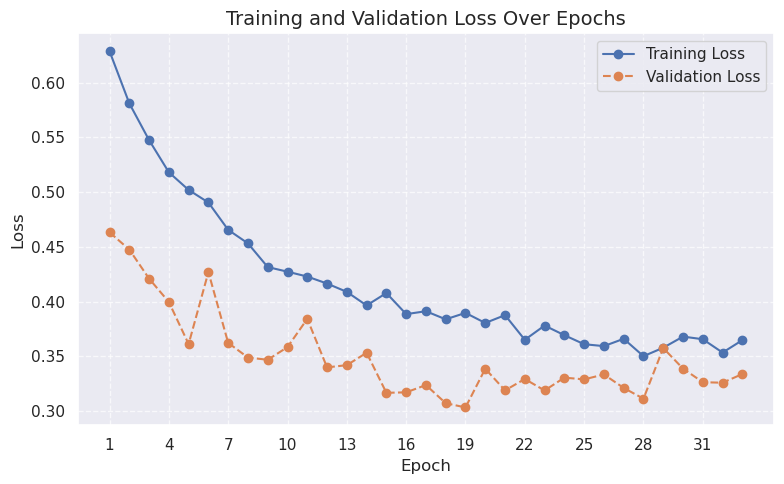

In [ ]:
from src.utils.plot import plot_training_loss

plot_training_loss(train_history["loss"], val_history["loss"])

In [ ]:
%aimport
from src.utils.train import evaluate_model

evaluate_model(
    model=model,
    test_loader=te_loader,
    device=device,
    checkpoint_path=SAVE_PATH,
    submission_path=SUBMISSION_ROOT / f"{SAVE_PATH.stem}.csv",
    use_gnn=True,
)

Modules to reload:


Modules to skip:

⚙️ Evaluating model. Loading model from: .checkpoints/lstm_gnn_generalizable_optimized.pt
   - Loading checkpoint from: .checkpoints/lstm_gnn_generalizable_optimized.pt
   - Detected full checkpoint dictionary.
   - Model state successfully loaded.
🧪 Performing inference on the test set...
   Generated 3614 predictions for 3614 IDs.
📄 Saved submission (3614 rows) → .submissions/lstm_gnn_generalizable_optimized.csv


,id,label
0,pqejgcvm_s001_t000_0,0
1,pqejgcvm_s001_t000_1,0
2,pqejgcvm_s001_t000_10,1
3,pqejgcvm_s001_t000_11,1
4,pqejgcvm_s001_t000_12,1
...,...,...
3609,pqejgvej_s001_t000_95,0
3610,pqejgvej_s001_t000_96,0
3611,pqejgvej_s001_t000_97,0
3612,pqejgvej_s001_t000_98,0
